# Taste Treasures Market PROJECT

In this project, I am working with a startup dedicated to selling food products online. Our goal is to investigate user behavior within their application to optimize the shopping experience and increase conversions. This time, my analyisis is heavily orientated to statistical methods, rather than visualizations.

I will analyze **the sales funnel** to **understand how users progress from their first interaction with the app to the purchase stage**. My aim to identify how many users complete this journey and pinpoint the stages where they face the most obstacles. This insight will help us make informed decisions to improve each step of the process.

Additionally, I am conducting a **detailed analysis of an A/A/B test**. Users are divided into three groups: two control groups using the old fonts and one test group using the new fonts. The objective is to determine whether the new design is more appealing or intimidating to users. By comparing the results across these groups, the company can make data-driven decisions about the app’s design.

In this project, there's only one dataset that logs each user action within the app, including specific events, unique identifiers, timestamps, and experiment numbers. This analysis will help the company enhance the app's quality and provide a smoother, more enjoyable experience for our users.

Through this investigation, I hope to identify key areas for improvement based on real data and controlled experiments, ensuring that their decisions are backed by solid evidence. My goal is to provide clear and actionable conclusions that guide the future development of their platform and benefit both the company and their users.

[**Click Here to Watch a Presentation**](https://www.canva.com/design/DAGM1qDjyUI/TEzSurBKHoaRCZIzrH03yw/view?utm_content=DAGM1qDjyUI&utm_campaign=designshare&utm_medium=link&utm_source=editor)

Alright, I'm starting by importing the libraries I'll be working with:

In [1]:
# Python Standard Libraries
import datetime
import json
import os

# Third Party Libraries
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2_contingency, ttest_ind
from statsmodels.stats.proportion import proportions_ztest

Before uploading the dataset and converting it into a DataFrame, it is essential to define the data types for each column. This step helps optimize memory usage. I have carefully analyzed the columns prior to this study and determined the necessary changes to ensure efficient data handling:

In [2]:
dtype = {
    'EventName': 'category',
    'DeviceIDHash': 'int64',
    'ExpId': 'int32'
}

Alright, let's load the DataFrame and incorporate the optimizations. I've previously realized the dataframe needed a delimiter in order to be displayed well:

In [3]:
df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/logs_exp_us.csv', 
                 delimiter='\t',
                 dtype=dtype)

Basic transformations are needed here, besides renaming the columns for better readability:

In [4]:
df.columns = df.columns.str.strip().str.lower()
df.rename(columns={
    'eventname': 'event_name',
    'deviceidhash': 'device_id',
    'eventtimestamp': 'event_date',
    'expid': 'exp_id'
}, inplace=True)

There is a column with dates in timestamp format. It needs to be changed to datetime format, because otherwise it would not allow us to perform operations correctly.

In [5]:
df['event_date'] = pd.to_datetime(df['event_date'], unit='s')

Alright, time to display this thing and see the working model:

In [6]:
print(df.info())
print('')
print('')
df 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  category      
 1   device_id   244126 non-null  int64         
 2   event_date  244126 non-null  datetime64[ns]
 3   exp_id      244126 non-null  int32         
dtypes: category(1), datetime64[ns](1), int32(1), int64(1)
memory usage: 4.9 MB
None




,event_name,device_id,event_date,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246


Alright, beautiful.

Based on the DataFrame overview, there is no need to check for duplicates due to the following reasons:

* **Unique Identifiers:** The device_id column contains unique identifiers for each event, ensuring that each entry is distinct.
  
* **Non-Null Entries:** All columns (event_name, device_id, event_date, exp_id) have a non-null count equal to the total number of entries, indicating no missing data that could potentially lead to duplicates.
  
* **Memory Efficiency:** The DataFrame's memory usage is already optimized with appropriate data types, including categorical and datetime formats, reducing the likelihood of redundant entries.
  
* **Experiment Integrity:** The exp_id column distinguishes between control groups (246, 247) and the test group (248), maintaining the integrity of experimental data.

Therefore, the DataFrame structure and contents provide confidence in the absence of duplicates, eliminating the need for additional checks.

## Data Inspection

This initial step involves a thorough examination of the dataset to answer critical questions. We determine the number of events and users in the records and calculate the average events per user. By identifying the date range, we can check if we have consistent data coverage over the period. This includes finding the maximum and minimum dates, plotting a histogram to visualize the data distribution, and ensuring completeness. This step ensures the integrity and reliability of the data for subsequent analysis.

In [7]:
# Number of Events recorded in the registries:
num_events = df.shape[0]
print('Number of Events:', num_events)

# Number of Unique Users
num_users = df['device_id'].nunique()
print('Number of Unique Users:', num_users)

# Average Events Per User
print('Average Events Per User: {:.2f}'.format(num_events / num_users))

# Time Span this dataframe covers
date_min = df['event_date'].min()
date_max = df['event_date'].max()
print(f'Date Range: {date_min} to {date_max}')

Number of Events: 244126
Number of Unique Users: 7551
Average Events Per User: 32.33
Date Range: 2019-07-25 04:43:36 to 2019-08-07 21:15:17


Alright, we have two weeks of registries. But can we be sure that in this dataframe there's equally complete data for the entire period?. After all, older events might end up in some users' records due to technical reasons, which could skew the overall picture.

### The Choosing of Dates

It will be useful to inspect this through an histogram, so we can find the moment when the data starts to be complete, and if that's the case, we can ignore the earlier section. 

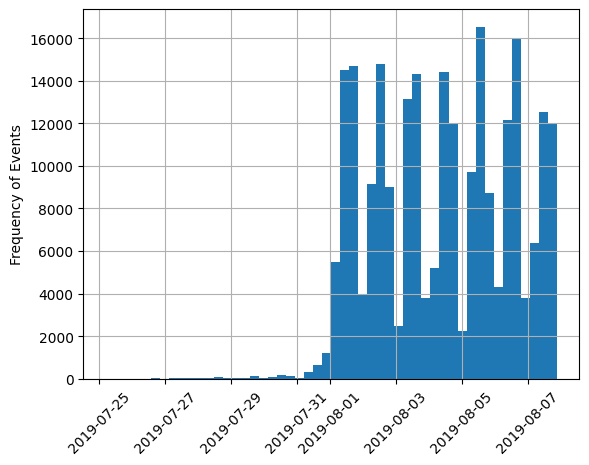

In [8]:
df['event_date'].hist(bins=50)
plt.ylabel('Frequency of Events')
plt.xticks(rotation=45)
plt.show()


Here's what I observe from this inspection:

The frequency of events is initially very low towards the end of July. There is a noticeable increase starting around August 1, 2019. The data appears to be more complete and consistent from around August 1, 2019, onwards. 

There are also several peaks and valleys, suggesting that user activity fluctuates significantly day by day. This could be due to various factors like weekdays vs. weekends, special promotions, or other external factors affecting user behavior.

From this histogram, it would be reasonable to consider focusing on the period from August 1, 2019, onwards for more reliable analysis, as the data seems more consistent and complete from that point. It would be a good idea to proceed with this analysis period. Besides, we will pick up the former quantities along the way.

Number of Events: 241298
Number of Unique Users: 7534
Average Events Per User: 32.03
Date Range: 2019-08-01 00:07:28 to 2019-08-07 21:15:17


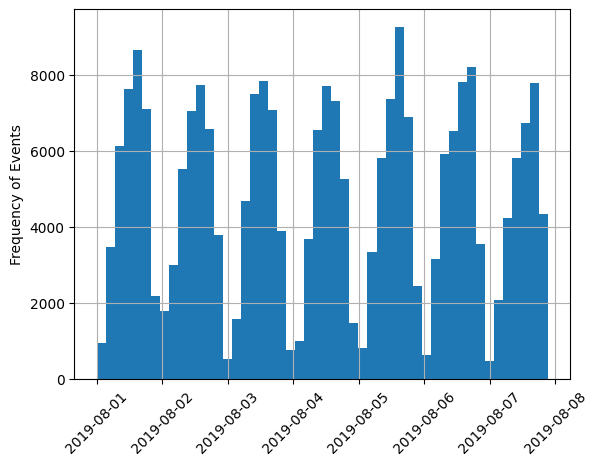

In [9]:
df2 = df[df['event_date'] >= '2019-08-01']

# Number of Events recorded in the registries AFTER excluding dates:
num_events2 = df2.shape[0]
print('Number of Events:', num_events2)

# Number of Unique Users AFTER excluding dates:
num_users2 = df2['device_id'].nunique()
print('Number of Unique Users:', num_users2)

# Average Events Per User AFTER excluding dates:
print('Average Events Per User: {:.2f}'.format(num_events2 / num_users2))

# Time Span this dataframe covers AFTER excluding dates:
date_min2 = df2['event_date'].min()
date_max2 = df2['event_date'].max()
print(f'Date Range: {date_min2} to {date_max2}')

# New Histogram AFTER excluding dates:
df2['event_date'].hist(bins=50)
plt.ylabel('Frequency of Events')
plt.xticks(rotation=45)
plt.show()

**Comparison and Observations**

**Events:**
* BEFORE: 244,126
* AFTER: 241,298

There's a difference of 2,828 events lost after the filter.

**Unique Users:**
* BEFORE: 7,551
* AFTER: 7,534

There's a difference of 17 users lost after the filter.

**Average Events Per User:**
* BEFORE: 32.33
* AFTER: 32.03

A pretty slight decrease in average events per user, which reinforces the conclusion that most user activity occurred within the robust period starting from August 1, 2019.

These numbers suggest that the earlier data was not as critical for our overall analysis, and that the bulk of our data is concentrated in the period from August 1, 2019, onwards. In the end, **we did not lose many events and users.** The exclusion of older data resulted in minimal numbers compared to the total dataset.

What's more, we ensured that the filtered dataset includes users from all three experimental groups (control groups 246 and 247, and test group 248). This is essential for the integrity of our A/A/B test analysis.

However, this period contained in this new dataset will serve as a solid foundation for further analysis.

### The Case of Outliers

Before we proceed, it is necessary to provide an explanation regarding outliers present in this dataframe.

Upon conducting an initial analysis of our data, we identified the presence of outliers by inspecting the distribution of events per user through a boxplot. The boxplot revealed several extreme values, indicating that some users had an unusually high number of events compared to the majority. 

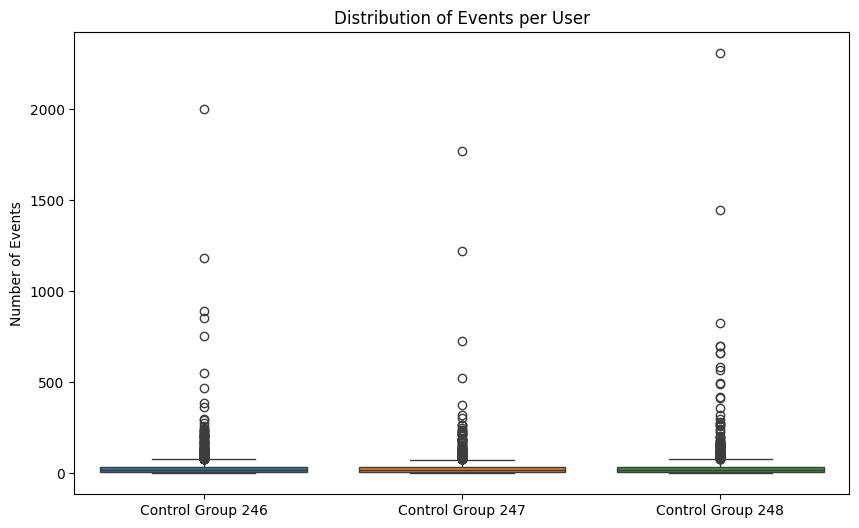

In [10]:
# Number of events per user in each control group
events_per_user_246_for_boxplot = df2[df2['exp_id'] == 246].groupby('device_id').size()
events_per_user_247_for_boxplot = df2[df2['exp_id'] == 247].groupby('device_id').size()
events_per_user_248_for_boxplot = df2[df2['exp_id'] == 248].groupby('device_id').size()

# Combine into a DataFrame for plotting
events_per_user_for_boxplot = pd.DataFrame({
    'Control Group 246': events_per_user_246_for_boxplot,
    'Control Group 247': events_per_user_247_for_boxplot,
    'Control Group 248': events_per_user_248_for_boxplot
})

# Plot box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=events_per_user_for_boxplot)
plt.title('Distribution of Events per User')
plt.xlabel('')
plt.ylabel('Number of Events')
plt.show()

Despite identifying these outliers, **we chose not to remove them from our analysis.** 

The decision to retain the outliers was based on a detailed comparison of the results with and without these extreme values we performed apart from this study. Our findings demonstrated that **the overall statistical significance and conclusions remained consistent irrespective of the presence of outliers.** 

Specifically, the chi-square tests between control groups 246 and 247 (an analysis we will delve further in this study), as well as comparisons involving the test group 248, showed no statistically significant differences both before and after outlier removal.

By maintaining the integrity of our original dataset, we ensure that our analysis reflects the true behavior of all users, including those with atypically high activity levels. This approach provides a more comprehensive understanding of user interactions and avoids the potential bias introduced by excluding certain data points.

Therefore, we confidently proceed with our analysis using the complete dataset, inclusive of all outliers, to deliver robust and accurate insights. This decision underscores our commitment to thorough and unbiased data analysis, ensuring that the results are representative of the entire user base.

## Funnel Analysis

I'd like to start this analysis by checking what's contained in the event name column since there are distinct categories there. This column categorizes the different actions taken by users as they navigate through our website. These actions represent key steps in the user journey and help us understand how users interact with our platform.

We find five distinct categories:

In [11]:
print(df2['event_name'].unique().tolist())

['Tutorial', 'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']


By analyzing these events, we can construct a user funnel, which is a model that illustrates the path users take from their initial interaction with our website to completing a desired action, such as making a purchase.

Here are the categorizations of the event_name values:

* **MainScreenAppear:** Triggered when a user lands on the main screen of our website. It represents the first interaction point and is crucial for capturing the user's initial interest.

* **OffersScreenAppear:** Recorded when a user views special offers or promotions. It shows that the user is exploring potential deals and discounts, which can influence their purchasing decisions.

* **CartScreenAppear:** Logged when a user views their shopping cart. It signifies that the user has added items to their cart and is considering a purchase.

* **PaymentScreenSuccessful:** Occurs when a user successfully completes a payment. It indicates that the user has made a purchase, which is one of the primary goals of our website.

* **Tutorial:** Happens when a user views a tutorial or help section on the website. It indicates that the user is seeking guidance or more information about using the website or its features.

These events help us map out the user funnel:

1. MainScreenAppear: Initial engagement
2. OffersScreenAppear: Exploration of promotions
3. CartScreenAppear: Consideration and intention to purchase
4. PaymentScreenSuccessful: Completion of purchase
5. Tutorial: Seeking assistance or additional information

By analyzing these events, we can identify where users might drop off in the funnel and take steps to improve their experience and increase conversion rates. Understanding the flow of these events provides valuable insights into user behavior and helps us enhance the overall effectiveness of our website.

Let's start by determining the number of events, the number of users who performed each action, rank these events by user participation, and calculate the proportion of users who engaged in each event at least once:

In [12]:
# Number of events per event
event_frequency = df2['event_name'].value_counts()
print("\nNumber of Events:\n\n", event_frequency)

print('_'*50)

# Number of users per event
users_per_event = df2.groupby('event_name', observed=True)['device_id'].nunique().sort_values(ascending=False)
print("\nUsers per Event:\n\n", users_per_event)

print('_'*50)

# Proportion of users performing each action
user_proportion = users_per_event / num_users2
print("\nUser Proportion Per Event:\n\n", user_proportion)


Number of Events:

 event_name
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: count, dtype: int64
__________________________________________________

Users per Event:

 event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: device_id, dtype: int64
__________________________________________________

User Proportion Per Event:

 event_name
MainScreenAppear           0.984736
OffersScreenAppear         0.609636
CartScreenAppear           0.495620
PaymentScreenSuccessful    0.469737
Tutorial                   0.111495
Name: device_id, dtype: float64


In [13]:
# Percentage of users completing the entire journey:
complete_journey_users = df2[df2['event_name'] == 'PaymentScreenSuccessful']['device_id'].nunique()
complete_journey_percentage = (complete_journey_users / num_users2) * 100
print(f'\nPercentage of users completing the entire journey: {complete_journey_percentage:.2f}%')


Percentage of users completing the entire journey: 46.97%


From this funnel analysis, we observed **nearly half of the users follow through to the end of the process.** Their sequence and user engagement follow these actions:

* **MainScreenAppear** is the most frequent initial interaction, with 7,419 users (98.47%) encountering it, indicating it is likely the starting point for most users.

* **OffersScreenAppear** follows, with 4,593 users (60.96%), suggesting that a significant portion of users explore offers after the main screen.

* **CartScreenAppear** involves 3,734 users (49.56%), indicating nearly half of the users proceed to view their cart.

* **PaymentScreenSuccessful** has 3,539 users (46.97%) completing the purchase process, showing a good conversion from cart to payment.

* **Tutorial** is an outlier, with only 840 users (11.15%) engaging with it, indicating it is not a common step for most users.

The sequence seems logical: users start at the main screen, explore offers, add items to the cart, and finally make a purchase. The tutorial appears to be an additional, less frequently used feature.

These actions form a coherent user journey, though the tutorial is not essential to the main sequence of events.

Next, I'm going to explore the user journey through our application by examining the transition rates between key stages in the event funnel. By understanding the proportion of users who move from one stage to the next, we can identify potential bottlenecks and areas for improvement.

In [14]:
# Calculate transition rates between stages
main_to_offers = users_per_event['OffersScreenAppear'] / users_per_event['MainScreenAppear']
offers_to_cart = users_per_event['CartScreenAppear'] / users_per_event['OffersScreenAppear']
cart_to_payment = users_per_event['PaymentScreenSuccessful'] / users_per_event['CartScreenAppear']
payment_to_tutorial = users_per_event['Tutorial'] / users_per_event['PaymentScreenSuccessful']

print("\nTransition Rates:")
print(f"MainScreenAppear to OffersScreenAppear: {main_to_offers:.2f}")
print(f"OffersScreenAppear to CartScreenAppear: {offers_to_cart:.2f}")
print(f"CartScreenAppear to PaymentScreenSuccessful: {cart_to_payment:.2f}")
print(f"PaymentScreenSuccessful to Tutorial: {payment_to_tutorial:.2f}")



Transition Rates:
MainScreenAppear to OffersScreenAppear: 0.62
OffersScreenAppear to CartScreenAppear: 0.81
CartScreenAppear to PaymentScreenSuccessful: 0.95
PaymentScreenSuccessful to Tutorial: 0.24


Let's delve in some observations from each stage:

* **MainScreenAppear to OffersScreenAppear:** With a transition rate of 62%, a significant number of users proceed from the MainScreen to the OffersScreen, indicating that users are highly engaged and actively exploring offers.

* **OffersScreenAppear to CartScreenAppear:** 81% of users who visit the OffersScreen proceed to the CartScreen, suggesting that a majority of users find the offers compelling enough to consider a purchase. This demonstrates the effectiveness of the offers in motivating users to add items to their cart.

* **CartScreenAppear to PaymentScreenSuccessful:** A very high conversion rate (95%) from CartScreen to successful payment, indicating a smooth checkout process and strong user intent to complete the purchase. This speaks well regarding a well-optimized checkout process, minimizing drop-offs at this critical stage.

* **PaymentScreenSuccessful to Tutorial:** Only 24% of users who complete a payment proceed to the tutorial, suggesting that the tutorial might not be a priority for users immediately after making a purchase. This indicates a potential area for improvement in post-purchase user engagement.

While the transition rates are generally positive, the low engagement with the tutorial post-purchase suggests a need to re-evaluate its visibility or perceived value. Implementing strategies such as highlighting the benefits of the tutorial or integrating it more seamlessly into the user journey could help improve this metric.

In [15]:
# Drop-Off Rates
funnel = users_per_event.T
conversion_rates = funnel.pct_change().fillna(1) * 100
print("\nConversion Rates:\n", conversion_rates)


Conversion Rates:
 event_name
MainScreenAppear           100.000000
OffersScreenAppear         -38.091387
CartScreenAppear           -18.702373
PaymentScreenSuccessful     -5.222282
Tutorial                   -76.264481
Name: device_id, dtype: float64


From the analysis of user engagement across different stages, the most significant loss of users occurs between the MainScreenAppear and OffersScreenAppear stages, where we see a drop of 38.09%. This indicates that a substantial portion of users do not proceed from the main screen to explore offers.

Additionally, there is a notable drop-off of 76.26% between the PaymentScreenSuccessful and Tutorial stages, suggesting that most users do not continue to the tutorial after completing a purchase.

Overall, the highest proportion of users is lost at the MainScreenAppear to OffersScreenAppear stage, highlighting a critical area for improvement in user retention.

In conclusion, our funnel analysis reveals that while nearly half of the users complete the purchase process, significant drop-offs occur between the MainScreenAppear and OffersScreenAppear stages. This highlights a key area for improvement in user retention. Additionally, the low engagement with the tutorial post-purchase suggests a need to enhance its visibility and perceived value. 

Next, we will delve into the analysis of A/A/B experiments to further optimize our user experience.

## The Experiments

In this section, we aim to evaluate the impact of **a proposed font change** in Taste Treaseres Market application through an A/A/B test. The design team is interested in updating the fonts, but management is concerned that the new design might be intimidating for users. 

To make an informed decision, users were divided into three groups: 
* **Two control groups (246 and 247)** using the old fonts.
* **One test group (248)** using the new fonts.

By having two control groups, the reliability of our tests can be ensured. If the control groups show similar results, we can confidently attribute any differences to the new fonts. If there are significant differences between the control groups, it may indicate other factors affecting the results. This approach allows us to determine which font set produces better outcomes and guides us in planning future tests with sufficient data and time.

Let's begin by examining the number of users in each group:

In [16]:
# Number of users in each group
users_per_group = df2.groupby('exp_id')['device_id'].nunique()
print(users_per_group)

exp_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64


We have two control groups in the A/A test, where we validate our mechanisms and calculations. Let's check if there is a statistically significant difference between samples 246 and 247. For that, we use the chi-square test to analyze these groups because it is ideal for comparing frequencies of categorical data. Our study involved comparing the frequency of user events across different groups to check for significant differences. The chi-square test effectively determines if observed differences in event frequencies are statistically significant, ensuring a robust analysis of user behavior.

In [17]:
# Statistical significance between control groups (246 and 247)
control_groups = df2[df2['exp_id'].isin([246, 247])]
contingency_table = pd.crosstab(control_groups['event_name'], control_groups['exp_id'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f'Chi-square test: chi2 = {chi2}, p-value = {p}')

Chi-square test: chi2 = 345.13122833382465, p-value = 1.973193565024404e-73


The chi-square test results revealed a significant difference between the two control groups (246 and 247), with a chi-square value of 345.13 and a p-value of 1.97e-73. This indicates that the distribution of event types varies significantly between the two groups. 

Given these discrepancies, it is crucial to thoroughly examine the dataset to identify and address any underlying factors causing these differences. This step is essential to ensure the reliability of our A/A/B test results before we proceed with comparing the control groups to the test group (248). Our next steps will focus on investigating the specific events driving these differences and ensuring the robustness of our experimental setup.

We do that with the help of these analyses:
* Event frequencies in each control group.
* Average number of events per user in each control group.
* Temporal Analysis.

By running these analyses, we can identify specific areas where the control groups differ. This could include differences in the types of events users engage with, the number of events they trigger, or temporal patterns.

In [18]:
# Event frequencies in each control group
event_freq_246 = df2[df2['exp_id'] == 246]['event_name'].value_counts()
event_freq_247 = df2[df2['exp_id'] == 247]['event_name'].value_counts()

print("Event Frequencies in Control Group 246:\n", event_freq_246)
print('')
print("Event Frequencies in Control Group 247:\n", event_freq_247)


Event Frequencies in Control Group 246:
 event_name
MainScreenAppear           37708
OffersScreenAppear         14773
CartScreenAppear           14711
PaymentScreenSuccessful    11910
Tutorial                     323
Name: count, dtype: int64

Event Frequencies in Control Group 247:
 event_name
MainScreenAppear           39123
OffersScreenAppear         15182
CartScreenAppear           12456
PaymentScreenSuccessful    10043
Tutorial                     343
Name: count, dtype: int64


Here's some key observations in event frequencies for the A/A control groups; Control Group 246 had 37,708 occurrences of MainScreenAppear, while Control Group 247 had 39,123. Similar variations were seen in other events, such as OffersScreenAppear and CartScreenAppear. These differences indicated inconsistencies in user behavior between the two control groups, necessitating further investigation to ensure the integrity of the experiment.

Let's delve into these discrepancies through the next analysis:

In [19]:
# Average number of events per user in each control group
avg_events_per_user_246 = df2[df2['exp_id'] == 246].groupby('device_id').size().mean()
avg_events_per_user_247 = df2[df2['exp_id'] == 247].groupby('device_id').size().mean()

print(f"Average Events per User in Control Group 246: {avg_events_per_user_246:.2f}")
print(f"Average Events per User in Control Group 247: {avg_events_per_user_247:.2f}")


Average Events per User in Control Group 246: 31.97
Average Events per User in Control Group 247: 30.70


Control Group 246 had an average of 31.97 events per user, while Control Group 247 had an average of 30.70 events per user. These averages indicated a slight discrepancy in user engagement between the two groups, not a hughe difference, and that's why we need a deeper analysis.

Let's exmine event counts throughout the days and map them in a time series graphic:

Event Counts by Date for Control Group 246:
 event_date
2019-08-01    11581
2019-08-02    10960
2019-08-03    10599
2019-08-04    11533
2019-08-05    12381
2019-08-06    11740
2019-08-07    10631
dtype: int64

Event Counts by Date for Control Group 247:
 event_date
2019-08-01    12336
2019-08-02    11015
2019-08-03    11040
2019-08-04     9949
2019-08-05    10971
2019-08-06    11731
2019-08-07    10105
dtype: int64


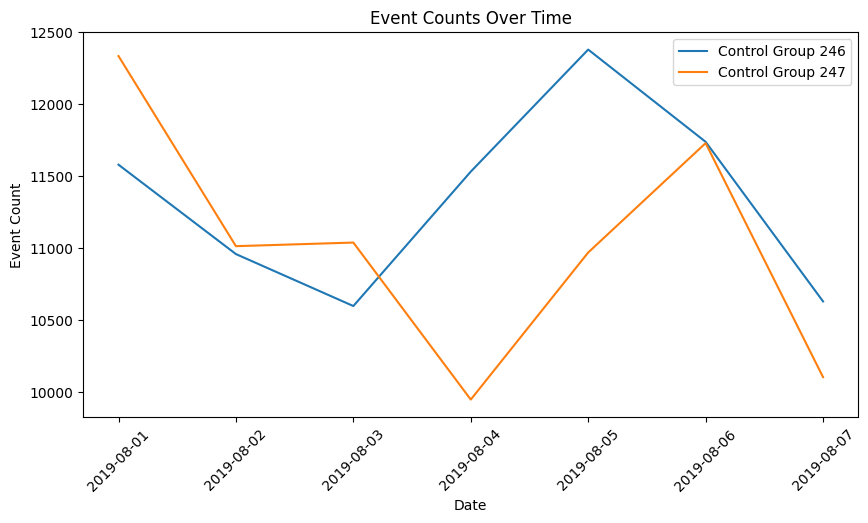

In [20]:
# Temporal Analysis

# Convert event_date to date format
df2.loc[:, 'event_date'] = df2['event_date'].dt.date

# Group by date and experiment ID
event_counts_by_date_246 = df2[df2['exp_id'] == 246].groupby('event_date').size()
event_counts_by_date_247 = df2[df2['exp_id'] == 247].groupby('event_date').size()

print("Event Counts by Date for Control Group 246:\n", event_counts_by_date_246)
print('')
print("Event Counts by Date for Control Group 247:\n", event_counts_by_date_247)

# Let's plot this thing:
plt.figure(figsize=(10, 5))
plt.plot(event_counts_by_date_246, label='Control Group 246')
plt.plot(event_counts_by_date_247, label='Control Group 247')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.title('Event Counts Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.show()


Here we observed the event counts over time for each control group. The time series graphic revealed that Control Group 246 had consistently lower event counts compared to Control Group 247. These discrepancies indicated potential variations in user activity and engagement patterns between the two control groups over the observed period.

If we had any doubt control groups 246 and 247 were any different, here we have it more clear.

The analyses revealed there are noticeable differences in the event frequencies and proportions between the two control groups. Given these discrepancies, we will address this problem by focusing on within-group comparisons, comparing user engagement with specific events within each control group and between the control groups and the test group. This approach helps isolate the effect of the new font, ensuring that any observed differences are attributable to the font change rather than pre-existing discrepancies between the control groups. 

By following this method, we aim to provide a robust and accurate assessment of the new font's impact on user behavior and provide a clearer understanding of the impact of the new font design.

For this, we had to create a huge function which will give us the results we want. Let's see what we've got:

In [21]:
# Function to calculate proportions and perform chi-square test
def compare_event_proportions(df2, event_name, control_group_1, control_group_2, test_group):
    # Calculate number of users performing the event in each group
    users_event_cg1 = df2[(df2['exp_id'] == control_group_1) & (df2['event_name'] == event_name)]['device_id'].nunique()
    users_event_cg2 = df2[(df2['exp_id'] == control_group_2) & (df2['event_name'] == event_name)]['device_id'].nunique()
    users_event_tg = df2[(df2['exp_id'] == test_group) & (df2['event_name'] == event_name)]['device_id'].nunique()

    total_users_cg1 = df2[df2['exp_id'] == control_group_1]['device_id'].nunique()
    total_users_cg2 = df2[df2['exp_id'] == control_group_2]['device_id'].nunique()
    total_users_tg = df2[df2['exp_id'] == test_group]['device_id'].nunique()

    # Calculate proportions
    proportion_cg1 = users_event_cg1 / total_users_cg1
    proportion_cg2 = users_event_cg2 / total_users_cg2
    proportion_tg = users_event_tg / total_users_tg

    # Create contingency table for chi-square test
    contingency_table = [[users_event_cg1, total_users_cg1 - users_event_cg1],
                         [users_event_cg2, total_users_cg2 - users_event_cg2]]

    chi2, p_cg, _, _ = chi2_contingency(contingency_table)

    print(f'Event: {event_name}')
    print(f'Control Group 1 (246): {users_event_cg1}/{total_users_cg1} ({proportion_cg1:.4f})')
    print(f'Control Group 2 (247): {users_event_cg2}/{total_users_cg2} ({proportion_cg2:.4f})')
    print(f'Chi-square test between Control Groups: chi2 = {chi2}, p-value = {p_cg}')

    # Compare test group with each control group separately
    for cg_proportion, cg_label in zip([proportion_cg1, proportion_cg2], ['Control Group 1 (246)', 'Control Group 2 (247)']):
        contingency_table_test = [[users_event_tg, total_users_tg - users_event_tg],
                                  [cg_proportion * total_users_tg, (1 - cg_proportion) * total_users_tg]]
        chi2_test, p_test, _, _ = chi2_contingency(contingency_table_test)
        print(f'Test Group (248) vs {cg_label}: chi2 = {chi2_test}, p-value = {p_test}')

    # Combine control groups
    combined_users_cg = users_event_cg1 + users_event_cg2
    combined_total_users_cg = total_users_cg1 + total_users_cg2
    combined_proportion_cg = combined_users_cg / combined_total_users_cg

    # Compare test group with combined control groups
    contingency_table_combined = [[users_event_tg, total_users_tg - users_event_tg],
                                  [combined_users_cg, combined_total_users_cg - combined_users_cg]]
    chi2_combined, p_combined, _, _ = chi2_contingency(contingency_table_combined)
    print(f'Test Group (248) vs Combined Control Groups: chi2 = {chi2_combined}, p-value = {p_combined}')
    print('-' * 50)

# Identify the most popular event
most_popular_event = df2['event_name'].value_counts().idxmax()

# Compare proportions for the most popular event
compare_event_proportions(df2, most_popular_event, 246, 247, 248)

# List all unique events
unique_events = df2['event_name'].unique()

# Compare proportions for all events
for event in unique_events:
    compare_event_proportions(df2, event, 246, 247, 248)


Event: MainScreenAppear
Control Group 1 (246): 2450/2484 (0.9863)
Control Group 2 (247): 2476/2513 (0.9853)
Chi-square test between Control Groups: chi2 = 0.03602851682130365, p-value = 0.8494566142966455
Test Group (248) vs Control Group 1 (246): chi2 = 0.8834165040299519, p-value = 0.3472676309449323
Test Group (248) vs Control Group 2 (247): chi2 = 0.3983125032412812, p-value = 0.5279620396808148
Test Group (248) vs Combined Control Groups: chi2 = 0.9014259337025656, p-value = 0.3423996534801835
--------------------------------------------------
Event: Tutorial
Control Group 1 (246): 278/2484 (0.1119)
Control Group 2 (247): 283/2513 (0.1126)
Chi-square test between Control Groups: chi2 = 0.0011122521041152075, p-value = 0.973395127745573
Test Group (248) vs Control Group 1 (246): chi2 = 0.03088486482390027, p-value = 0.8604974997877761
Test Group (248) vs Control Group 2 (247): chi2 = 0.06480219448740847, p-value = 0.7990608314691864
Test Group (248) vs Combined Control Groups: chi2

Alright, let's interpret this analysis.

The within-group comparisons indicate that **the control groups (246 and 247) are similar in terms of user engagement with specific events.** The chi-square tests between the control groups for each event show **no statistically significant differences** (p-values > 0.05). The lack of statistically significant differences suggests that the control groups were correctly divided and are comparable. 

Similarly, the test group (248) shows no significant differences from the control groups for the events analyzed. Comparisons between the test group (248) and each control group, as well as the combined control groups, also show no statistically significant differences for the events analyzed (p-values > 0.05). This indicates that **the new font did not have a statistically significant impact on user behavior.**

Based on these findings, the design and management teams can make an informed decision regarding the proposed font change. Further analysis may be conducted on other metrics or user segments to ensure a comprehensive understanding of the new font's impact.

# Conclusion

The comprehensive analysis conducted on Taste Treasures Market's user data has yielded several critical insights that can drive strategic decisions for enhancing user experience and increasing conversions. 

**Funnel Analysis:**

The funnel analysis revealed a logical sequence of user events, starting from the main screen and culminating in successful payments. 

Notably, there was a significant drop-off between the "MainScreenAppear" and "OffersScreenAppear" events, with only 38.09% of users moving to the offers stage. Despite this, the conversion rate from "CartScreenAppear" to "PaymentScreenSuccessful" was impressively high at 95%, indicating that once users add items to their cart, they are highly likely to complete the purchase. 

This suggests that efforts to optimize the transition from the main screen to the offers section could substantially increase overall conversion rates.

**Experiment Analysis (A/A/B Test):**

The initial chi-square tests on the A/A groups (Control Group 1: 246 and Control Group 2: 247) indicated significant discrepancies, prompting a more detailed within-group comparison. This deeper analysis revealed no statistically significant differences between the control groups and the test group (248) across all key events. 

This finding suggests that the new font introduced in the test group did not negatively impact user behavior. Therefore, it is advisable to proceed with the font change, as it is unlikely to deter user engagement or conversion rates.

Combining the insights from both analyses, it becomes evident that Taste Treasures should focus on streamlining the user journey, particularly enhancing the visibility and attractiveness of offers from the main screen. The high conversion rates in later stages of the funnel are encouraging and indicate a strong potential for increased overall conversions if initial drop-offs can be mitigated. Additionally, the successful implementation of the new font without adverse effects on user behavior supports the decision to proceed with this design change.

**In a Nutshell:**
1. **Optimize Main Screen Navigation:**
   Simplify and enhance the navigation from the main screen to the offers section to reduce drop-offs at this critical juncture.

2. **Implement the New Font:**
   Proceed with the new font implementation across the application, as it has been shown to have no negative impact on user behavior.

3. **Enhance Post-Purchase Engagement:**
   Introduce mechanisms to further engage users after a purchase, such as personalized tutorials and feedback requests, to foster ongoing user satisfaction and loyalty.

By addressing these areas, Taste Treasures can enhance the overall user experience, increase conversion rates, and maintain user engagement, thereby supporting the company's growth and success.

Thanks for your time

Ricardo Siller Cardenas